# Train-test splitting, preparing folders

In [ ]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image


TEST_SIZE = 0.3
DATASET = Path('dataset')
LIKED = DATASET / 'liked'
DISLIKED = DATASET / 'disliked'
TRAIN_FOLDER = Path('train')
TEST_FOLDER = Path('test')


def create_folder(folder, liked, disliked):
    if os.path.exists(folder):
        shutil.rmtree(folder)

    liked_subfolder = folder / 'liked'
    disliked_subfolder = folder / 'disliked'

    liked_subfolder.mkdir(parents=True, exist_ok=True)
    disliked_subfolder.mkdir(parents=True, exist_ok=True)

    for filename in liked:
        path_to_image = str(LIKED / filename)
        img = Image.open(path_to_image).convert('RGB')
        filename, _ = os.path.splitext(filename)
        img.save(liked_subfolder / f'{filename}.jpg', 'jpeg')

    for filename in disliked:
        path_to_image = str(DISLIKED / filename)
        img = Image.open(path_to_image).convert('RGB')
        filename, _ = os.path.splitext(filename)
        img.save(disliked_subfolder / f'{filename}.jpg', 'jpeg')


random.seed(42)

liked_imgs = os.listdir(LIKED)
disliked_imgs = os.listdir(DISLIKED)
random.shuffle(liked_imgs)
random.shuffle(disliked_imgs)

print(f'Liked: {len(liked_imgs)} images')
print(f'Disliked: {len(disliked_imgs)} images')

test_liked = liked_imgs[:int(TEST_SIZE * len(liked_imgs))]
test_disliked = disliked_imgs[:int(TEST_SIZE * len(disliked_imgs))]

train_liked = liked_imgs[len(test_liked):]
train_disliked = disliked_imgs[len(test_disliked):]

print('\nAfter splitting:')
print(f'- Test liked: {len(test_liked)} Test disliked: {len(test_disliked)}')
print(f'- Train liked: {len(train_liked)} Train disliked: {len(train_disliked)}')

assert (len(test_liked) + len(train_liked)) == len(liked_imgs)
assert (len(test_disliked) + len(train_disliked)) == len(disliked_imgs)

create_folder(TRAIN_FOLDER, train_liked, train_disliked)
create_folder(TEST_FOLDER, test_liked, test_disliked)

Liked: 1917 images
Disliked: 1497 images

After splitting:
- Test liked: 575 Test disliked: 449
- Train liked: 1342 Train disliked: 1048


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


# Model and datagenerators creation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG19

from utils import plot


def build_model(use_dropout, verbose=True):
    """
    The part responsible for feature exctraction is VGG19
    """

    feature_extractor = VGG19(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )

    model = models.Sequential()
    model.add(feature_extractor)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    if use_dropout:
        model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))

    if verbose:
        model.summary()

    return model

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


def get_train_test_generators(train_dir, test_dir, batch_size):
    """
    Returns keras datagenerators
    """

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        fill_mode="nearest"
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    return train_generator, test_generator


def fit_head(model, train_generator, test_generator,
             steps_per_epoch, validation_step, epochs):
    """
    Fitting classifier part
    """

    model.get_layer('vgg19').trainable = False

    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        x=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=validation_step
    )

    return history


def finetune(model, train_generator, test_generator,
             steps_per_epoch, validation_step, epochs):
    """
    Finetune layers in fifth block
    """

    vgg19 = model.get_layer('vgg19')
    vgg19.trainable = True
    set_trainable = False

    for layer in vgg19.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        x=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=validation_step
    )

    return history

# Check performance of the finetuned model

In [ ]:
model = build_model(use_dropout=False, verbose=False)

batch_size = 64
train_size = len(os.listdir(TRAIN_FOLDER / 'liked')) + len(os.listdir(TRAIN_FOLDER / 'disliked'))
test_size = len(os.listdir(TEST_FOLDER / 'liked')) + len(os.listdir(TEST_FOLDER / 'disliked'))

train_generator, test_generator = get_train_test_generators(
    train_dir=TRAIN_FOLDER,
    test_dir=TEST_FOLDER,
    batch_size=batch_size
)

history_1 = fit_head(
    model=model,
    train_generator=train_generator,
    test_generator=test_generator,
    steps_per_epoch=train_size // batch_size,
    validation_step=test_size // 512,
    epochs=3
)

history_2 = finetune(
    model=model,
    train_generator=train_generator,
    test_generator=test_generator,
    steps_per_epoch=train_size // batch_size,
    validation_step=test_size // 512,
    epochs=10
)

Found 2390 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.
Epoch 1/3
37/37 [==============================] - 37s 967ms/step - loss: 0.7373 - accuracy: 0.5213 - val_loss: 0.6957 - val_accuracy: 0.5156
Epoch 2/3
37/37 [==============================] - 36s 960ms/step - loss: 0.6720 - accuracy: 0.5753 - val_loss: 0.6525 - val_accuracy: 0.5625
Epoch 3/3
37/37 [==============================] - 36s 955ms/step - loss: 0.6431 - accuracy: 0.6357 - val_loss: 0.6702 - val_accuracy: 0.5391
Epoch 1/10
37/37 [==============================] - 38s 992ms/step - loss: 0.6348 - accuracy: 0.6531 - val_loss: 0.6203 - val_accuracy: 0.6875
Epoch 2/10
37/37 [==============================] - 36s 977ms/step - loss: 0.5897 - accuracy: 0.6853 - val_loss: 0.6993 - val_accuracy: 0.5859
Epoch 3/10
37/37 [==============================] - 37s 984ms/step - loss: 0.5724 - accuracy: 0.7110 - val_loss: 0.6578 - val_accuracy: 0.6484
Epoch 4/10
37/37 [==============================] - 36s 977ms

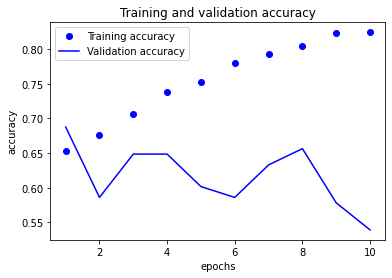

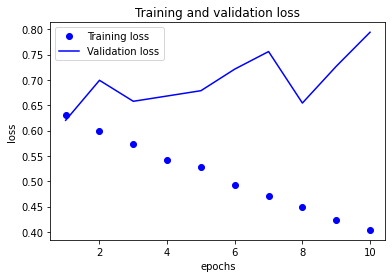

In [ ]:
from utils import plot


plot(history_2)

# Training on the whole dataset

In [ ]:
def copy(dir):
    for folder in ['liked', 'disliked']:
        for filename in os.listdir(dir / folder):
            shutil.copyfile(
                dir / folder / filename,
                WHOLE_DATASET / folder / filename
            )


WHOLE_DATASET = Path('data')
data_liked = WHOLE_DATASET / 'liked'
data_disliked = WHOLE_DATASET / 'disliked'

if os.path.exists(WHOLE_DATASET):
    shutil.rmtree(WHOLE_DATASET)

data_liked.mkdir(parents=True, exist_ok=True)
data_disliked.mkdir(parents=True, exist_ok=True)

copy(TRAIN_FOLDER)
copy(TEST_FOLDER)

In [ ]:
def train_on_whole_dataset(dir, batch_size, epochs, dataset_size,
                           use_dropout=True, model_name='model.h5'):
    """
    Training of final model using whole dataset
    """

    train_datagen = ImageDataGenerator(
        rescale=1./255,
    )

    train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="binary"
    )

    model = build_model(use_dropout=use_dropout, verbose=False)

    # fit head
    model.get_layer("vgg19").trainable = False
    model.compile(
        optimizer=optimizers.RMSprop(lr=2e-5),
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    h1 = model.fit(
        x=train_generator,
        steps_per_epoch=dataset_size // batch_size,
        epochs=3
    )

    # finetune
    vgg19 = model.get_layer("vgg19")
    vgg19.trainable = True
    set_trainable = False
    for layer in vgg19.layers:
        if layer.name == "block5_conv1":
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-5),
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    h2 = model.fit(
        x=train_generator,
        steps_per_epoch=dataset_size // batch_size,
        epochs=epochs
    )

    # save model
    model.save(model_name)
    print(f"Model saved in '{model_name}'")

In [ ]:
train_on_whole_dataset(
    dir=WHOLE_DATASET,
    batch_size=64,
    epochs=8,
    dataset_size=len(os.listdir(data_liked)) + len(os.listdir(data_disliked)),
    use_dropout=False
)

Found 3414 images belonging to 2 classes.
Epoch 1/3
53/53 [==============================] - 19s 349ms/step - loss: 0.7009 - accuracy: 0.5647
Epoch 2/3
53/53 [==============================] - 19s 350ms/step - loss: 0.6531 - accuracy: 0.6168
Epoch 3/3
53/53 [==============================] - 19s 352ms/step - loss: 0.6268 - accuracy: 0.6416
Epoch 1/8
53/53 [==============================] - 22s 386ms/step - loss: 0.5958 - accuracy: 0.6941
Epoch 2/8
53/53 [==============================] - 21s 391ms/step - loss: 0.5164 - accuracy: 0.7649
Epoch 3/8
53/53 [==============================] - 21s 387ms/step - loss: 0.4577 - accuracy: 0.8079
Epoch 4/8
53/53 [==============================] - 21s 384ms/step - loss: 0.3891 - accuracy: 0.8591
Epoch 5/8
53/53 [==============================] - 21s 386ms/step - loss: 0.3470 - accuracy: 0.8741
Epoch 6/8
53/53 [==============================] - 21s 389ms/step - loss: 0.2949 - accuracy: 0.9062
Epoch 7/8
53/53 [==============================] - 21s 390

# Some tries with model

In [11]:
import cv2
import numpy as np
from skimage import io
from tensorflow.keras.models import load_model


class Model:
    IMG_SIZE = 224

    def __init__(self, model_path):
        self.model = load_model(model_path)

    @staticmethod
    def process_external_image(image_url):
        img = io.imread(image_url, plugin='matplotlib')
        dim = (Model.IMG_SIZE, Model.IMG_SIZE)
        resized_img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
        image = np.expand_dims(resized_img, axis=0)
        return image

    def predict(self, img_url):
        image = self.process_external_image(img_url)
        prediction = self.model.predict(image)
        return round(prediction[0][0])


url = 'https://images-ssl.gotinder.com/60237e6afab4900100b06186/640x800_75_d27ebee7-6447-4199-ae84-2e369fbe2f77.webp'

model = Model('model.h5')
print(model.predict(url))

1
